In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

In [3]:
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [52]:
multivariate_data=test_new.loc[500:24999,['dateTime','AEDATZ_HO_V0','AEWIHO_T9AV2','AEWIHOAVABV2','RWWIHOA_HWT0',
                                          'AEWIHOAKZ_V0','RWWIHOA_MWT0','AEDAHO_T9_V2']]
multivariate_data = multivariate_data.set_index('dateTime')
multivariate_data=multivariate_data.loc[::-1]
univariate_data=test_new.loc[500:24999,['dateTime','AEDAHO_T9_V2']]
univariate_data = univariate_data.set_index('dateTime')
univariate_data=univariate_data.loc[::-1]

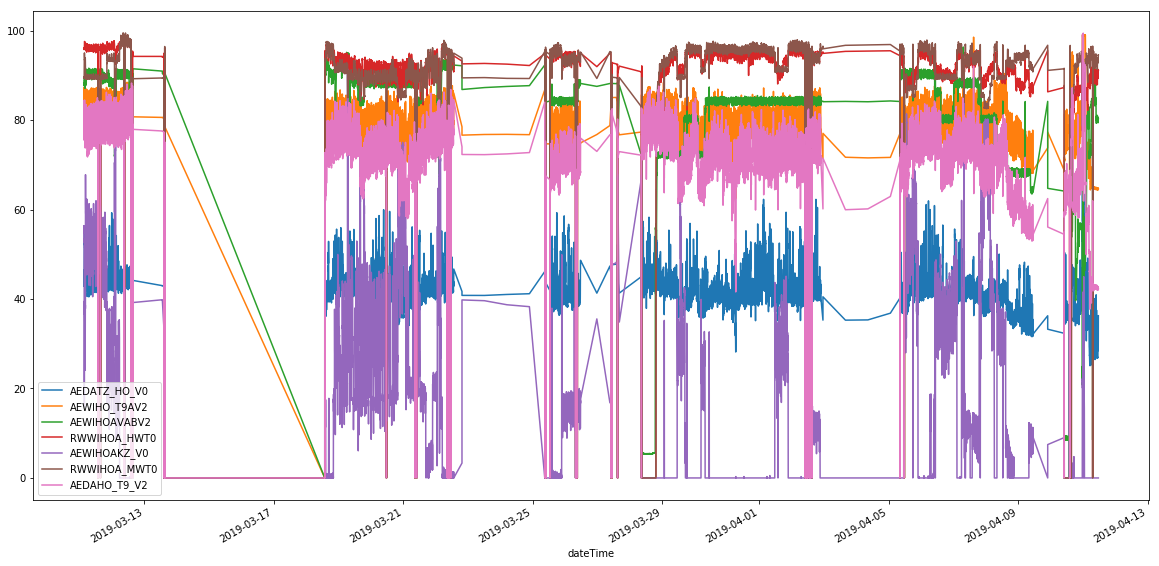

In [53]:
multivariate_data.plot()
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [54]:
# remove this line if you want do not want to count mean. Just comment it and uncomment the below lines.
multi_mean=multivariate_data.mean()
multivariate_data_mean= multivariate_data.replace(0,multi_mean)

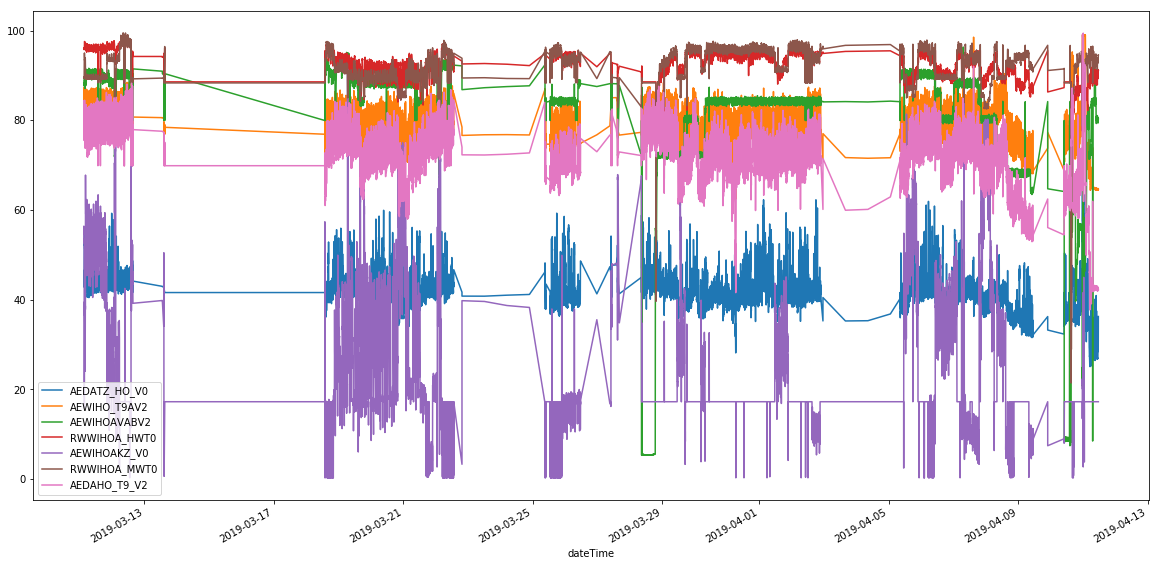

In [55]:
multivariate_data_mean.plot()
plt.show()

# train and test dataset making

In [78]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(multivariate_data_mean)
df_normalized = pd.DataFrame(np_scaled)

In [67]:
# dataset=np.array(multivariate_data_mean)
dataset=np.array(df_normalized)

NumberOfElements=int(len(dataset)*0.9)
print('Number of Elements for training: ',NumberOfElements)
print('dataset length: ',len(dataset))

multiple_ip_train_data=dataset[0:NumberOfElements]
print(multiple_ip_train_data.shape)
multiple_ip_test_set=dataset[NumberOfElements:len(dataset)]
print(multiple_ip_test_set.shape)

Number of Elements for training:  22050
dataset length:  24500
(22050, 7)
(2450, 7)


In [68]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_1 = 4
# split into samples
X_Conv_Lstm, y_Conv_Lstm = split_sequence(multiple_ip_train_data, n_steps_1)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = X_Conv_Lstm.shape[2]
n_seq = 2
n_steps_2 = 2
# X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [69]:
X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [70]:
print(X_Conv_Lstm.size)
print(X_Conv_Lstm.shape)
print(X_Conv_Lstm.shape[0])
print(X_Conv_Lstm.shape[2])

529104
(22046, 4, 6)
22046
6


In [71]:
# define model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

lr = 0.01

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size=32
epochs=10

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_2, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_Conv_Lstm_train, y_Conv_Lstm, batch_size=batch_size, epochs=epochs,validation_split=0.2, verbose=1,
         callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/trained_model_file/conv_LSTM_100.h5', save_best_only=True)])

Train on 17636 samples, validate on 4410 samples
Epoch 1/10
17636/17636 [==============================] - 5s 266us/step - loss: 0.0057 - val_loss: 0.0031
Epoch 2/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0033 - val_loss: 0.0044
Epoch 3/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
17636/17636 [==============================] - 3s 146us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10
17636/17636 [==============================] - 3s 142us/step - loss: 0.0023 - val_loss: 0.0041
Epoch 6/10
17636/17636 [==============================] - 2s 134us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/10
17636/17636 [==============================] - 2s 137us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0020 - val_loss: 0.00

In [72]:
X_Conv_Lstm_test, y_Conv_Lstm_test = split_sequence(multiple_ip_test_set, n_steps_1)

x_input = X_Conv_Lstm_test.reshape((X_Conv_Lstm_test.shape[0], n_seq, 1, n_steps_2, X_Conv_Lstm_test.shape[2]))
yhat = model.predict(x_input, verbose=1)
print(yhat)

2446/2446 [==============================] - 0s 155us/step
[[0.3492557 ]
 [0.33720744]
 [0.3402214 ]
 ...
 [0.16729575]
 [0.22320628]
 [0.27940613]]


In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(y_Conv_Lstm_test,yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  0.008328398856411208
RMSE Error:  0.09126006167218609


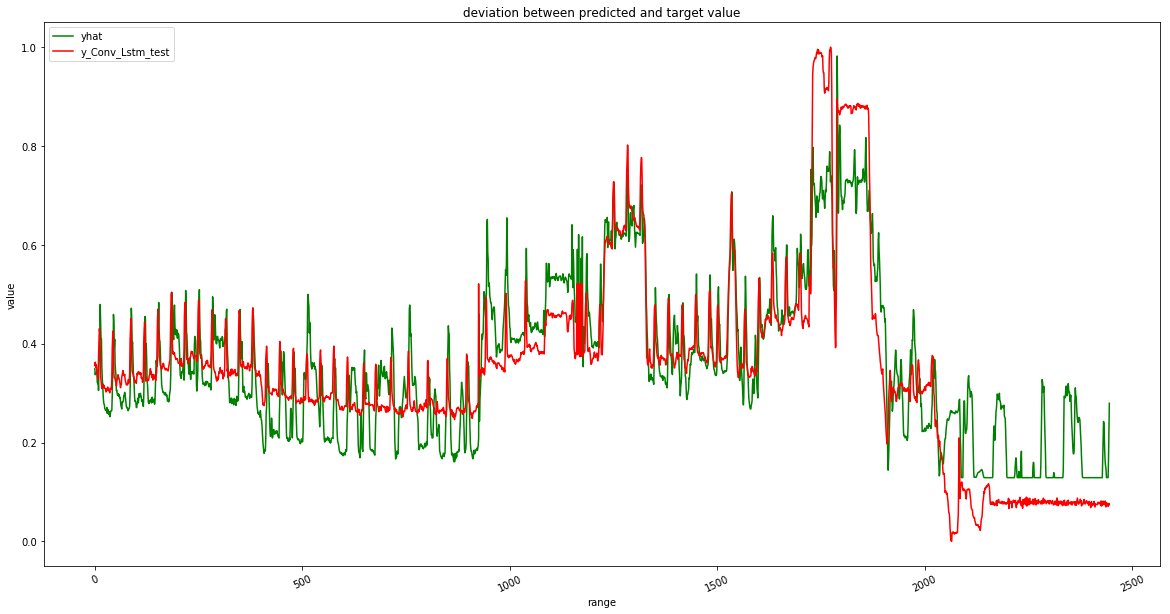

In [74]:
# my_data_1.index[0:-1]
plt.plot(yhat,color='green')
plt.plot(y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['yhat', 'y_Conv_Lstm_test'], loc='upper left')
plt.show()

In [ ]:
for i,j in multivariate_data_mean.iterrows():
    for o in j:
        print(o)
    

46.11938837586608
79.17830627909903
88.2697689645123
96.06365927057912
54.778230911941755
89.56613036318787
83.32736135675994
46.534540534907656
81.65911664779162
88.1703602269234
96.10336224014164
54.704686601075096
89.37737955765017
84.3148141327593
46.55563074179414
86.05542972190763
88.26138509507709
96.03853581699444
56.41528729146339
89.39284230647803
84.3809434064285
45.94044924535742
87.1136907008934
88.27855206582537
95.95750773362215
55.23093172226419
89.34483528795917
83.27985328724495
44.218946986350886
87.26626399899334
88.05258682295265
96.01827879615136
53.03721159002981
89.45548779113192
79.96312394257812
43.149993894821186
86.6153894551403
88.09730079327376
95.99883284743191
53.41457875821948
89.5897167655425
76.76810831291303
42.85596920639996
83.38492512897949
88.27895129770323
96.01827879615136
52.914460669345495
89.57182089310335
76.26673655413882
42.8788308641327
79.8361016735875
88.23703195052721
95.97452046597084
53.469153361835424
89.55392502066418
76.360077666

74.69844130431886
41.79122331063015
78.63973826601233
90.21921822413677
95.78329537614708
54.20403380969386
89.39365665805407
74.97961560976069
42.02500963226397
78.43588775638607
90.23638519488505
95.80274132486656
52.423289236802
89.36029803678703
75.39778457627503
42.058771135509936
78.60041525103813
90.1377749210519
95.76303835530399
51.98991460206845
89.39771848481745
75.84509998832378
41.91294277120167
78.50226500566252
90.08308015378412
95.82299834570959
51.957706639278705
89.48151724821464
75.41858527434
41.80087591013936
78.52680256700641
90.33938701937471
95.7363026485956
51.700399405298974
89.42944840293241
75.24397597678549
41.567089588505524
78.52019630049075
90.28109916520617
95.63501754438023
51.79738325679399
89.4131812336453
74.7767561529317
41.53818601806501
78.53970051591794
90.25195523812187
95.71847884412331
49.0518326631379
89.43270580923655
74.21427530309168
41.58456458958331
78.61834654586637
90.29028149839708
95.71928991624694
52.171353491408176
89.497784417501

42.92838460221733
89.53602914822498
75.81261818244509
42.290781487290246
78.72341764187745
90.34298010627552
95.20962010667576
43.510451966205956
89.85493717029313
76.08660750459016
42.293149447094954
78.78885113879451
90.1864812101517
95.43892602181488
50.139029641460645
89.77521016477608
76.04590729245928
42.44501972411099
78.76871775512771
90.35735245387876
95.45674982628715
50.88410787962078
89.44652992379555
76.03473554951458
42.57278109739031
78.7441801937838
90.2407767455416
95.36033115481341
50.83722879836411
89.41236688206926
76.33581426676143
42.58000699000044
78.86844092110229
90.11342177650202
95.58801492570532
51.133719591241245
89.41399558522134
76.10881875152319
45.01128712443547
78.72593431483578
90.27590915079388
95.55236731676077
50.97697487128872
89.45304473640383
80.52881770928431
46.08325891281543
78.90713476783692
90.34577472942058
95.67553158606638
50.83365013583191
89.55473937224018
83.87263644905293
46.39955326901822
83.08953064049327
90.31343694731336
95.67634

42.0165997597515
78.25217063042658
89.44231298980762
96.55225109606012
54.92012278447064
89.35948368521099
74.92967336390045
41.98709968035254
77.97659494148733
89.36086968672275
96.44854266659745
52.816047449710176
89.3619267399391
74.81617315741177
42.166630800812385
78.12790990310809
89.58324184269466
96.41045195015863
52.816047449710176
89.45060168167572
75.02134434710786
42.163612103962116
78.21442053605134
89.41237059896758
96.46393325469893
53.14886306520415
89.49778441750178
74.94019860528063
41.88646590766024
78.14049326789984
88.39752316542973
96.2338162674362
51.19813551682073
89.39202795490198
74.94148181293144
42.08589873609694
78.08198062161823
89.21235542815624
96.20950388597514
50.84849948846793
89.30741483992875
75.25488813955656
42.388988553083465
77.97565118912797
88.81272431841137
96.10659663751257
48.78003254486031
89.37250337931076
75.48843193200526
42.314235134974155
78.16660374984271
89.5077870177778
96.12685365835566
48.65800155042758
89.62388973838556
75.32280

76.17583941371319
43.971888340391864
78.57776519441299
88.11047544524338
96.27270816487514
25.967848233395337
93.32801753755774
76.04410982220031
42.96323688175122
78.13640367434252
88.26138509507709
96.12847580260285
24.519564555053073
93.3524182914884
75.83714116224526
42.534812398384474
78.27733736001007
88.10169234393028
96.15035496769312
22.5767090158042
93.48910025174385
75.52168268292665
42.011800574040464
78.1574808103687
88.23343886362639
96.18924686513206
22.73971639518807
93.5224588730109
75.61245737987413
42.07505763767811
78.30218950547376
88.17475177757994
96.10578556538898
24.05845353830123
93.48502849386372
75.44426412057372
42.0961478445646
78.14143702025922
88.26457895010002
96.10659663751257
22.333001747883085
93.40285843361859
75.46698963011491
41.93402845908089
78.0684535044671
87.48168523760286
96.12037497249031
21.96958751930259
93.52083016985884
74.91310921017882
41.92141139080855
78.03479300364918
87.98272124432594
95.93562856853191
20.240915282084227
93.431340

74.59200363764879
42.09371661865824
77.78344029193406
90.24516829619812
96.94604639431459
35.38313112142633
93.84218124665509
74.59829233468562
42.20702620671729
77.87938844847113
90.29028149839708
96.96873663152846
34.43943711272947
93.78686492618549
74.6945867836273
42.108823659931325
77.80546118031963
90.28628917961842
97.03112983830486
35.331418748878605
93.68272723562099
74.85995404745243
43.83814380149918
77.87120926135648
90.19366738395328
97.02707447768688
34.59349783578286
93.66320266002977
77.23955978337105
45.54276756838637
78.05240971435762
90.16372499311326
96.90796556899923
34.408662012867666
93.57614649032844
81.97219122497548
46.17062488018982
80.35925506480433
90.06830857430306
97.071643879991
34.53928319529271
93.5615080241934
83.43611075629711
46.328473803811995
85.28815905373095
90.28389378835121
97.0092506732146
34.28895505220828
93.62577228088257
83.85620943202682
46.042266997952076
86.03655467472002
90.1812911957394
97.0092506732146
33.76468099124199
93.503738717

17.272872145074913
97.62929345764842
76.94002385394862
42.740879129480135
78.97665785831131
91.14383925327671
97.54403404524695
17.272872145074913
97.52434141550788
77.06302077660119
42.94511114362789
78.87945136529508
90.83762840295273
97.43627025516626
17.272872145074913
97.41857502179134
77.3263526184097
43.31329274119998
78.96250157292059
90.41444261241371
97.32931753720919
17.272872145074913
97.3429197741545
78.10825707880029
43.325968556566714
78.9278973197433
90.2347882673736
97.2450451653425
17.272872145074913
97.15905507807295
78.28980157495617
43.12410902123093
79.23587517302127
90.07270012495958
97.22803243299386
17.272872145074913
97.32339519856323
77.90642614718763
43.05119483907679
79.48722788473637
90.14256570358631
97.96051958071527
17.272872145074913
98.12718999745859
77.66966943787276
42.54322678990422
79.52875298854914
90.21921822413677
98.04884731319996
17.272872145074913
98.36962842031386
77.00562906953144
42.343201971516336
79.60771360261734
90.14017031231913
98.2

80.49484082043539
89.21954160195784
94.72749707593664
42.106005156489246
89.39527543008936
78.8587033607894
47.68659365095749
80.52283880709702
90.03157924153929
94.70481672984623
40.507237670231966
89.41399558522134
78.72710111049378
46.959941802416886
80.43569900591419
89.96929906859205
94.6602473275421
41.34929975988712
89.46199267262341
78.51409843593639
46.355009414447835
80.51749087706052
90.22161361540395
94.553294609585
40.971212665445854
89.36111238836305
78.15280691388364
45.29086002763644
80.70561218069713
90.21682283286957
94.462543551853
40.882819001943176
89.40748077261307
78.2768323617525
44.165934512173614
80.74430602743173
91.48079095819644
94.25429583855707
39.219457355937344
89.25860340095066
77.94301715619244
42.995163668049265
80.61029319239965
90.96418490823656
94.24781715269177
39.84250110487711
89.42781969978034
77.5750451179728
42.90838969062605
80.51591795646156
90.43600113381856
94.06225967660973
39.6440670632971
89.36111238836305
77.53755782270811
42.9186342

71.34755512699249
40.199909131802
76.0620359884233
90.5733368998048
95.57262433760384
17.272872145074913
96.20801161066723
71.47594446042196
40.318609895523274
76.06518182962124
90.67314486927151
95.68606563254973
17.272872145074913
96.50413765084
71.5204991932444
42.581190969902785
76.2202718006795
90.65358250725605
96.00045499167909
17.272872145074913
96.74739042527126
75.27363178718892
43.765229619345035
76.09223606392351
90.6859202893633
96.06446045157922
0.31969623734039393
96.83526094654863
78.9673205213702
44.2249843800514
79.65206996350824
90.64360171030935
96.12847580260285
17.272872145074913
96.8881441434069
79.85052492008847
44.24423535098271
83.58846105448599
90.65837328979043
96.17061198853621
17.272872145074913
96.9223071851332
80.03566435676228
44.09781499672327
84.32238580596452
90.57493382731627
96.17142306065979
17.272872145074913
96.92312153670922
79.98058438255966
42.279289651825856
84.44916320624134
90.57213920417118
96.21598257184047
17.272872145074913
96.94021298

73.1798287201855
47.95355400489336
76.6801937838178
92.29282859777788
94.77044433399357
38.68820420407575
91.06958227041416
73.39436928482822
45.86871904310564
76.71416886875551
92.00897473261446
94.7485651689033
38.89379906550776
91.12002241254434
73.2501847427198
44.35754493904176
76.66226248898954
92.27725855454108
94.7210183900713
38.29007799736926
91.08178761293787
73.23670616464709
42.96803606746227
76.6603749842708
92.3048055541139
94.51278056789886
38.93244792189793
90.97276381291721
73.21474960014858
41.906959605588284
76.8576192273814
92.20659451215862
94.50953627940444
34.91593742680604
90.81005239557902
73.21384841614953
40.90245207660585
76.6109852774632
92.21817223661677
94.40419581457114
34.56594493011508
91.08503508812522
73.21359373371502
40.822962738887156
76.64338744180193
92.18303983136448
94.37989332423349
34.79157890381233
91.06632486411004
73.13489196371128
40.72469692599954
76.7144834528753
92.18343906324232
94.27536393152376
34.480769966018784
91.03215189126698

42.78725770099844
75.94784195293822
94.3193296098307
94.90252050553532
41.85084721690141
91.40150998658207
76.43891167534807
43.88872956877735
75.8160312067447
93.97399403547577
94.9584350264464
43.48307729470726
91.26565230901942
79.41874513654504
44.35150302633397
79.82855165471247
94.36005126137312
94.77125540611719
42.0915122721914
90.82144338652672
80.38643063743487
44.572026061657155
83.30439159431232
94.23668861111223
94.77531076673516
38.13297680907856
90.9117470314154
81.31380284758471
44.33278981726672
83.88291179061281
94.15604377178309
94.89198645905199
38.3120881698573
91.0492433432469
80.87649841430796
42.9661968315071
84.06128098653579
94.12290752592014
94.6448567394406
38.71039261073287
91.03134747080773
78.06370234597786
41.67856445961666
83.66459041147603
94.2067462202722
94.72345160644208
38.826699143029145
91.01262731567572
74.93544779832912
41.473089718472174
80.95507738769348
94.30575572598322
94.5759749556754
38.74045477391834
90.95649664363009
74.54180181161493


45.04623260758378
76.61161444570278
88.64744232097445
94.03714611414853
18.97210118025269
92.93506310877123
73.54446050032169
44.40031282375863
76.74342519189632
88.61510453886723
93.96665207725955
18.428322709528423
92.89519960601272
73.45021820407351
43.50188899022511
76.66226248898954
87.50883300529782
93.71707925015394
18.235611382691054
92.73655994655468
73.62252066650001
42.66014706476471
76.88184220460552
88.29412210906217
93.73490305462622
15.751733012763452
92.63242225599022
73.3531548100892
41.5562484900867
77.05423430225242
88.54523896024051
93.646585213265
17.945739717583415
92.5950018079598
73.2975605732784
41.22905428837068
76.9856549641374
88.50331961306448
93.5047860673635
18.150259931819487
92.51120304456259
72.99237755064458
41.21940168886147
77.0057883478042
88.67578778430301
93.59472605297192
18.712289930936702
92.56977677133631
73.30757644978954
41.23207750422821
76.95514030451744
88.56520055413384
93.3378733590008
19.598903573287547
92.36883055439169
73.0346156528

57.584797002814206
85.1965084974111
66.83062011646432
39.73896587218603
74.95784572794766
88.20828725532076
89.84069851113865
55.81801061171294
85.2526491005735
66.4261893081963
39.264167336308226
74.40417767711087
88.19311644396183
89.79694018095812
52.51078823467163
85.39583594232045
66.32539873473766
38.82786622328578
74.13835409588525
87.60664481537523
89.72725721619275
54.48620995244222
85.54145590767874
66.03395387035019
38.93934109439691
73.93481817037876
88.25659431254267
89.51658617764953
54.55599387181999
85.26241138836912
66.97018119283848
38.59591913760712
73.94928903988927
87.8609555215765
89.44690321288418
50.87140432658902
85.20058025529126
67.60944389894514
39.285845014138616
74.32741915188122
88.21866728414531
89.21597515349787
49.47966106990407
85.36979655412095
68.29851661195565
40.03180658070491
74.77381401786838
88.14760400988499
89.17221682331734
49.03053892211385
85.32505687302302
68.23316607880736
40.80786021662133
75.21077136026173
89.03908879316197
89.09118873

74.76940984019127
88.02863291028063
90.24827214437084
18.205909182631377
89.25371729149444
68.81003158845826
38.71278066537321
74.57216559708066
88.30849445666539
90.15994441188616
17.76607268557165
89.28381850645735
68.6487686300201
38.92311333932314
74.77633069082673
88.19551183522904
90.01328872436655
17.894029092429513
89.1642279981818
68.8850110767268
39.04779726865779
74.99874166352083
88.24341966057307
89.9687193220624
18.093895996937448
89.19514356472072
69.18993941692611
39.01527849240857
75.16452749465208
88.08731999632708
89.87877933645399
17.315072089430775
89.08938710212097
69.05076526194284
38.973694587594046
75.19724424311059
87.48048754196927
89.68755424663023
16.960856141890055
89.01535062651939
69.07335853252765
38.90741430809887
75.24034226752235
88.13403012603752
89.55872236358287
16.265861705242482
88.85832973909666
68.81773083436316
38.65799222134242
75.28564238077261
87.9807250849366
89.42826833628831
16.29196776883182
88.78673631822315
68.62180657613555
38.55795

69.03831031134732
49.834093686431686
75.18591921479803
88.24222196493946
91.88827976053592
33.861304879611204
89.42050046671282
68.46773839647237
49.317119255788185
75.11136277840693
88.01066747577661
91.89800273489566
33.823190725728296
89.56937783837523
68.47415933246558
48.41028554974221
75.2475777022776
88.51010655498821
91.58765884526079
33.59129409259971
89.46686885096283
68.5129298353811
46.76530815969124
75.22587139801183
89.24828629716427
91.64842990778999
34.095707275469856
89.49941312065383
68.21724842665029
45.58494346315207
74.90814143702026
88.38714313660519
91.5828023036427
33.74285254771066
89.44734427537159
68.48263242115227
44.47861366256772
74.54888637221593
88.21866728414531
91.48232827155093
27.462119822148857
89.43433451238863
68.12955440761257
43.48382199919616
75.03806467849503
88.19670953086262
90.97671382259777
31.699076278702602
89.53846227183632
68.33857522026112
42.839678185224535
75.16358374229269
88.18952335706102
90.78548873277398
31.15780357070839
89.06

70.13554101210015
39.76248278597159
76.37724927645652
88.15399171993086
92.73016273370872
41.839754760966656
89.36355544309116
69.9681166978424
39.76728197168264
76.43890776393606
88.28374208023762
92.82253593568792
39.80939847645432
89.47825984191051
69.98005738582978
39.73837388223485
75.66345790864476
88.14800324176286
92.49193502521
39.94109605346913
89.33101117340017
70.18959246108648
40.28668310922522
76.01201711337612
88.26697434136723
92.5259703810308
40.23490284944713
89.45954961789529
70.3910413690474
41.50987443757565
75.99125456146973
88.14560785049567
92.34365719344318
38.0698120174703
89.29196202221769
70.46858727261755
43.29700623903181
76.03403800176167
88.19191874832823
92.45871074151279
37.2655076133599
89.4180574119847
70.23504348016886
44.27616213728076
75.97741286019883
88.2246557623133
92.26667457956543
36.4527947502139
89.51487586948168
69.89480733861558
44.48524756522667
76.05228388070971
88.19670953086262
92.03170105068459
35.91778470165102
89.38958490017392
70

42.625201581616395
75.2824965395747
88.30050981910804
90.7862998048976
31.67581497224334
89.55473937224018
75.59756335519424
43.494663097614996
77.43236441424438
88.22705115358052
90.70040528878373
31.13418579591097
89.55636807539227
77.36166041976367
43.7151816139309
82.01113627784069
88.31967294924566
90.63557886563652
31.82987569529673
89.58890241396648
77.97537162085386
43.0626279274468
83.1968038253429
88.18113948762581
90.55455078226423
31.542509792919148
89.55311066908811
77.21452254096273
41.12782852572721
83.58783188624639
88.10768082209829
90.61937720541144
31.031299248110415
89.50104182380589
73.01740989531376
40.44210532594831
82.81584245627279
88.34602225318487
90.67285850995172
31.45232679815036
89.50104182380589
71.2239117027754
40.335488387642606
78.82471372845099
88.28653670338271
90.39979426463205
31.84920187088563
89.47988854506258
70.924375773353
40.160164462942646
76.81986913300615
88.13602628542685
90.33577891360845
30.72246137053968
89.37737955765017
70.728064593

66.36764173469301
38.90439561124861
76.11740279350698
88.10528543083109
87.32963899872158
40.6040432875579
85.21847612773044
66.11637792208911
38.28921863381915
76.01044419277716
88.07693996750255
88.81083473663648
56.66508073204058
86.42742076681925
66.2782824843527
37.742687636185934
75.96388574304771
88.27615667455817
90.75307552120042
63.51231329009722
86.55108303297497
66.34478888393457
37.80594695932722
76.00824210393858
88.1739533138242
91.57551254565372
67.24986983663474
86.15488112900113
66.7728463857428
37.57938653030352
76.07996728325155
88.05458298234197
91.92798273009844
71.65734921336873
86.11583197781864
66.27584341026832
37.90053881931174
76.02460047816788
88.13642551730473
92.30314315175706
71.86222764333681
85.6895288588819
66.24849443499289
40.075758445324134
76.02302755756891
88.21507419724449
92.51624740667108
72.75778794201811
85.58620551989345
71.46464537626
41.074816051549945
76.49333081666038
88.20229877715276
92.67587035704484
72.69104448787766
85.582948113589

89.06863195212412
91.3858997089537
37.923265087819466
89.31473407299629
69.11418608587579
39.58893483112515
76.01201711337612
88.744854899174
91.25625675378276
35.624512608180275
89.48396030294275
69.64534099627066
39.53289914109037
75.24506102931925
88.33963454313901
91.05044225685765
32.1419357670615
89.49941312065383
69.97479721400926
39.50334483360428
75.75279979866615
88.20189954527491
90.52862614767945
36.14932137165382
89.92734494274264
69.60977851248218
39.74435704784825
75.80030200075501
88.15319325617511
91.08772190117284
37.346922185967294
89.3806369639543
70.43096773839648
39.90286122752325
75.75783314458286
88.16636790814474
91.00750488992416
38.05549736734153
89.47988854506258
70.19922141620674
39.882367529595214
75.77482068705172
88.29651750032939
91.07962107106032
37.91378372898173
89.37982261237828
70.36600412663907
41.3549809447021
75.91418145212029
88.30569983352032
90.76523171193092
37.57738945095558
89.46768320253885
72.26799213854099
43.4229328953632
76.0129608657

88.80191294327689
19.96160137040408
89.03080344423046
70.44701762950993
39.561215240586975
76.2001384170127
86.47003165908792
88.59286404898087
19.719325218017087
88.79975601232292
70.06698245982483
39.757624853166156
76.6109852774632
87.67491346649048
88.57017381176699
17.735206721231485
88.64436382805224
70.32311952285832
39.67328210164929
76.55373096766075
85.38092709626679
88.4972564496307
18.84273113179885
88.5508027768594
70.69275679238051
39.58170893851502
76.45967031584246
85.23999824337973
88.1812449462541
19.21849069767913
88.34498038157534
69.97620776287732
39.652191894762815
76.62797281993205
85.73943732259134
88.0532142442069
18.858298663292658
88.33846556896708
70.48040061938768
39.6774847784019
76.17339876683026
85.80810520558447
87.96732961921649
18.379294333879848
88.1489103429701
70.55114356331288
40.233019898002404
76.65628539071348
85.66038941077367
87.8838683194734
19.696780343021796
88.145652936666
70.78982508410397
43.00961545326953
76.4134264502328
85.8468306977

95.71580560077247
82.33926207919605
45.97835919726886
83.72373222599724
92.23014919295277
95.24284439037298
5.9250127087952125
95.8158715334568
83.63909265660422
45.821097744590595
86.0673839184598
92.29921630782377
95.18207332784377
6.463655152250071
95.73288712163559
83.6468016979874
45.11434760402688
86.99823832892916
92.31598404669417
95.24364557137312
4.476638602823047
95.79879001259363
82.47933741817836
43.17954820230728
86.72895432238579
92.22815303356344
95.22177629740631
5.6466104998378075
95.73125841848356
78.497152258563
42.35581903978869
85.90537309676607
92.16786902000551
95.17801796722576
3.2353614616907316
95.76380268817458
76.33337519267705
42.249202101482986
81.84377752611049
92.13113968724177
95.11562476044935
6.891591460584282
95.69139491572504
75.73622814530846
41.90210167278285
79.44696111740281
92.27526239515173
95.11481368832577
4.4219565344875065
95.5864528047013
75.34424738989686
41.58817527638474
79.20127091984395
92.23334304797571
95.0929345232355
5.207133092

78.092991065811
92.07684415185184
93.42943548885643
22.39455369500052
92.04259336813922
75.40934324061064
42.557086585173295
78.05492638731597
92.21138529469302
93.22037670343693
22.807174533398673
91.9205598051356
75.57714957852015
42.475762530506685
78.17100792751981
92.18423752699806
93.17742944538
22.661702250943783
91.88476806025723
75.58562266720683
42.32875018629608
78.03510758776899
92.21457914971596
93.12800350145771
22.480979793068034
91.846523329534
75.57355463800222
42.06961223392877
78.3050207625519
91.5790020001517
92.91976567928528
22.913281527999434
91.72287099449508
74.86059565127783
41.780382212211315
78.38555429721907
91.64886757877844
92.89950865844222
20.79399687747715
91.63581482479374
73.85208259703987
41.492991426449045
78.08764313577451
91.88601131423141
92.91328699341992
23.000958760038166
91.59839437676331
73.19702957999341
41.46527183591087
77.6333836667925
92.20020680211277
92.70179499162964
21.60080704431761
91.51133820706198
73.11948367642322
41.188717629

82.76299232414748
92.32556561176298
96.81721451126724
17.272872145074913
97.29329398360035
76.55870057887358
41.09833296533551
82.31470995344155
92.16627209249405
96.85529533658257
17.272872145074913
97.20380469028768
72.78168660895432
41.07120536474851
80.55492638731597
92.29682091655657
96.74834261862549
17.272872145074913
97.09803829657116
73.34185572592722
41.17782230305421
76.77740027683403
92.2529054099912
96.661637030388
17.272872145074913
97.02481617254558
73.40682423542374
41.19292482532003
76.76985025795898
92.1522989767687
96.55711752880173
17.272872145074913
96.8857010886788
72.54724163250656
43.25903754002598
77.22914307285768
92.20419912089142
96.53199407521706
17.272872145074913
96.84828064064838
72.13382347294372
45.390309820426396
76.43104316094124
92.14351587545565
96.40478433641691
0.6294903215700878
96.75634829260763
72.28968912286584
47.11358804928646
76.65848747955205
92.11716657151639
96.33833576902248
0.5451537788684311
96.57980282959365
72.30625327658747
47.768

84.11376511591699
95.28578175730644
0.9395921109293122
96.15349971065692
66.80853621074854
38.01444039732197
74.82037246759783
84.34931192385852
95.24041117400219
17.272872145074913
96.08597804766359
66.30948108258058
37.863815106806285
74.77601610670693
84.17484759323064
95.11724690469656
0.4429274728994946
96.06563912049631
66.21254502981351
37.973453001465884
74.32962124071976
84.2211584910632
95.16019416275351
0.542473331362972
95.978582950795
66.01354009367611
37.87346996581913
73.90210142192022
84.28343866401045
95.19827498806885
0.4429274728994946
95.94522432952795
66.13872140797854
37.945141420976526
73.9533786334466
84.15169214431435
95.09536773960629
17.272872145074913
95.978582950795
66.03331226652477
38.0487938905191
74.27456901975589
84.31817183738487
95.11562476044935
17.272872145074913
95.95987272677978
66.24631004334303
41.6154225199946
74.4265131496162
84.11256742028337
95.11238047195495
17.272872145074913
95.92407105078465
69.89687745791552
38.52661564225443
74.492261

84.23712776617788
95.22177629740631
17.272872145074913
95.5840097499732
67.2351831636887
38.08617059957375
74.42147980369951
84.15807985436022
95.17882903934937
17.272872145074913
95.47987205940872
67.21502406944916
38.247634729004616
74.60897193909652
84.30140409851447
95.13669285341604
17.272872145074913
95.44326596295436
67.16353903576447
38.36515151282355
74.30634201585505
84.27705095396458
95.11238047195495
0.8848958996250861
95.3724868936569
67.37461689884562
38.53141482796546
74.367371335095
84.26786862077364
95.02811799121174
17.272872145074913
95.31960369679862
68.05021103378343
38.45192549024677
74.37366301749087
84.19121610022319
94.98517073315479
0.44244794981254304
95.28218324876819
67.74849071271116
38.41336480128976
74.85843714609287
84.20079766529199
94.96572478443535
17.272872145074913
95.21628035781019
67.64487904151638
38.25243391471568
74.97451868629672
84.22674773735335
94.98354858890758
17.272872145074913
95.24556722119705
67.53972458249713
38.23436692368672
74.57

95.17801796722576
17.261535437740672
94.305914744739
75.95359470542645
46.21398023585061
84.60425317729961
84.28343866401045
95.11562476044935
16.718814140274205
94.28557581757171
72.8017134642375
44.641917027953774
83.89895558072229
84.34412190944623
95.11805797682017
18.531745707230037
94.21967292661371
69.50745004893821
43.9712963504407
80.62444947779035
84.08142733380977
95.20394260181057
18.06473024677884
94.27174177189596
68.89104509132912
43.40427391438307
77.83566125581982
84.24591086749095
95.24364557137312
17.33949716017052
94.28800894118305
68.58855582521419
40.628329096161494
77.27035359255066
84.31218335921687
95.2193430810355
18.256010458082088
94.26767001401579
68.01194989573693
39.026115071820136
77.04385302629923
84.21317385350586
95.11238047195495
18.55930210768545
94.16028484826393
67.91064995740926
38.74233949186657
76.85352963382408
84.07024884122949
95.00948311461588
17.217338605989326
94.03906563683631
68.16781554565908
38.500730768664155
76.88813388700139
84.205

94.99327156326734
16.685531530288518
94.81194486919279
68.00565630096098
38.60373702016842
74.5554926387316
84.16606449191757
95.18855201370909
16.460075790760353
95.02753948338926
68.24510676679473
38.91647943666417
74.58160312067447
84.14410673863487
95.34736389195926
16.864607943190972
95.1959414306429
68.42511337286528
41.211583806300176
74.91726437649426
84.11296665216125
95.20313152968698
16.414215440097554
95.19675578221893
73.23708818829887
42.4619027352376
74.9852145463697
84.23153851988775
95.24688985986752
15.646574853003989
95.21546600623415
75.33461843477662
42.60411589373717
79.34189002139172
84.1025866233367
95.30603877814951
17.720607245910944
95.24882462750118
75.74649870425414
41.99189886606359
81.6207373851768
84.30060563475872
95.20475367393419
16.785788250398177
95.23092875506201
75.72788239783905
40.45116593550636
82.00484459544481
84.24750779500242
95.28497068518286
17.08185093179076
95.19431272749084
73.10138163261628
38.940583821393645
81.78778155278722
84.2027

17.272872145074913
88.35441490522537
71.58572238517544
43.12168231433185
76.86107965269913
5.453467684425165
88.58830464518908
17.272872145074913
88.35441490522537
71.26448457368903
41.87799728805337
76.36655341638354
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
71.7953848016494
40.85548151513637
76.39549515540456
5.474267509312083
88.58830464518908
17.272872145074913
88.35441490522537
72.39060703754176
40.738561240275885
76.47571410595194
5.480056371541155
88.58830464518908
17.272872145074913
88.35441490522537
72.18004343706875
41.03382865569386
76.79690449226123
5.458098618258472
88.58830464518908
17.272872145074913
88.35441490522537
71.98514770405744
42.56372048783226
76.95073612684033
5.466202947404195
88.58830464518908
17.272872145074913
88.35441490522537
72.19070091740531
45.105286994468834
76.48955580722286
5.4523097560294005
88.58830464518908
17.272872145074913
88.35441490522537
72.34798201393465
47.93726298371793
76.36686800050333
5.480056371541155

77.95016987542469
5.413065340410052
88.58830464518908
17.272872145074913
88.35441490522537
75.9693850163663
43.948967935564745
78.43462941990687
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
75.74855085694762
43.08495634232276
78.08198062161823
5.436140864975787
88.58830464518908
17.272872145074913
88.35441490522537
76.07171347991027
42.757111403561176
78.24273310683276
5.434982936580019
88.58830464518908
17.272872145074913
88.35441490522537
76.42607470110077
42.32389225349064
78.46986284132376
5.4292342314636635
88.58830464518908
17.272872145074913
88.35441490522537
76.17006008154542
42.58362219580913
78.33050207625519
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
76.3094938167023
42.55531061531978
78.32704165093745
5.439614260288207
88.58830464518908
17.272872145074913
88.35441490522537
75.77936743152371
43.1541965715738
78.42330439159431
5.4072764781809814
88.58830464518908
17.272872145074913
88.35441490522537
76.0606690781828


74.46656274317273
47.00033720832181
77.74160060400152
67.62908164691136
82.72237841954684
17.272872145074913
83.920856546905
74.39954208098273
47.165416543561385
77.2628035736756
67.93289710596811
82.85364846452674
17.272872145074913
84.13319375479735
74.32918605844844
47.45523855523
77.58839813766203
68.22433637681102
83.0432514101033
17.272872145074913
84.32926379340256
74.7521058319143
46.23986510944087
77.32980999119165
68.13171458114589
83.1088889053741
17.272872145074913
84.52207642570367
74.29734585639515
44.92575587400899
77.82056121806971
68.11654376978694
83.20206328835346
17.272872145074913
84.6319046461836
73.93515315034334
44.08093650460392
77.4808103686926
68.07502365448877
83.49457348239255
17.272872145074913
84.82471727848471
74.82670329653106
43.101188616403796
77.35057254309801
67.93130017845665
83.53589859620232
17.272872145074913
84.94837954464043
75.06551215853942
43.181920681119244
77.45312696615075
67.68058255915619
83.54076502894391
17.272872145074913
85.0386831

91.52365338536065
17.272872145074913
93.4175068308704
74.51034363321341
44.39427091105085
77.29614949037372
72.2693537633593
91.58442444788986
17.272872145074913
93.4362170548856
79.71057692232344
45.79219417415007
77.47514785453629
72.00665918772283
91.54553255045091
17.272872145074913
93.4874715485918
83.44817878550175
46.05553480327
81.64590411476028
72.12563028732718
91.62979503119413
17.272872145074913
93.48991460331992
84.18822716732792
46.21641146175696
85.30325909148107
72.24140753190862
91.6516741962844
17.272872145074913
93.5574362663132
84.35872726175633
45.62166491615389
86.02176922108973
72.38553023981859
91.66949800075669
17.272872145074913
93.52407764504619
83.73076853755076
43.61454784123861
86.11708820938719
72.07532707071596
91.60630361298011
17.272872145074913
93.54198344860214
79.43248329479137
42.63604268003522
85.22146722033472
72.32285083499347
91.58442444788986
17.272872145074913
93.55662191473719
76.80996439147745
42.29558067300129
81.53642884107211
72.13201799